## Convolutional & Conditional VAEs

In this problem you will implement: 
1. a **convolutional** variational autoencoder
2. a (convolutional) **conditional** variational autoencoder,

trained on the MNIST dataset. 
The convolutional parameterization will help you achieve better marginal log likelihood. Using the conditional VAE, you'll be able to generate novel images of a specified class.


In [ ]:
%pylab inline
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.distributions import MultivariateNormal
import pandas as pd
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample', 'grid', 'show']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True, 
          transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




---
# 1. Convolutional variational autoencoder (20 points)


Your task is to implement a VAE for MNIST, using a **convolutional network** in the encoder, and a **convolutional network** in the decoder.

- **Overall Goal:** achieve better estimated marginal likelihood than in the lab
  - Keep `z=20` as in the lab 


**Encoder**: you are free to design the convolutional network how you want. 
  - We used three `Conv2d + ReLU` layers, with an output size of `B x 64 x 7 x 7`.
  - Hint: Flatten the output of your convolutional network before mapping it to the encoder outputs, e.g. $\mu = \texttt{linear(flatten(conv(x)))}$


**Decoder**: you are free to design the convolutional network how you want. 
  - We used three `ConvTranspose2d + ReLU` layers, with an input size of `B x 64 x 7 x 7`.
  - Hint: Map the $\mathbf{z}$ input to the convolutional input size.
    - $\hat{x}=\texttt{deconv(reshape(linear(z)))}$

In [ ]:
class Encoder(nn.Module):
  def __init__(self, zdim=20):
      super(Encoder, self).__init__()
      self.en_conv = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),         
                                  # nn.BatchNorm2d(16),
                                  nn.ReLU(),
                                  
                                  nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),    
                                  # nn.BatchNorm2d(32),    
                                  nn.ReLU(),
                                  
                                  # nn.MaxPool2d(2,2),                                                            
                                  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),        
                                  # nn.BatchNorm2d(64),  
                                  nn.ReLU(),
                                  # nn.ReLU(),
                                  )
      # self.fc = nn.Linear(7 * 7 * 64 , 512)
      self.fc_mu = nn.Linear(7 * 7 * 64 , zdim)
      self.fc_logvar = nn.Linear(7 * 7 * 64 , zdim)


  def forward(self, x):
      x = self.en_conv(x)
      x = x.view(-1, 7 * 7 * 64)
      # x = self.fc(x)
      mu = self.fc_mu(x)
      logvar = self.fc_logvar(x)
      return mu, logvar
    


class Decoder(nn.Module):
  def __init__(self, zdim=20):
      super(Decoder, self).__init__()
      self.fc = nn.Linear(zdim, 7 * 7 * 64)
      self.de_conv = nn.Sequential(nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
                                  # nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  
                                  nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
                                  # nn.BatchNorm2d(16),  
                                  nn.ReLU(),
                                  nn.ConvTranspose2d(in_channels=16, out_channels=1,  kernel_size=3, stride=2, padding=1, output_padding=1),
                                  nn.Sigmoid(),
                                  )
    
  
  def forward(self, x):
      x = self.fc(x)
      x = x.view(-1, 64, 7, 7)
      x = self.de_conv(x)
      return x
    
    


class VAE(nn.Module):
    def __init__(self, zdim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(zdim)
        self.decoder = Decoder(zdim)
    
    def reparameterize(self, mu, logvar):
        if self.training:
          std = torch.exp(0.5*logvar)
          eps = torch.randn_like(std)
          z = mu + std*eps
        else:
          z = mu
        return z
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        xhat = self.decoder(z)
        return xhat, mu, logvar


**Loss**: does anything change from the lab?

In [ ]:
def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
    BCE = nn.functional.binary_cross_entropy(
        xhat.view(x.size(0), -1), x.view(x.size(0), -1), reduction='none'
    ).sum(1).mean()
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

    loss = BCE + kl_weight*KLD
    return loss, BCE.item(), KLD.item()

In [ ]:
images = next(iter(test_loader))[0]
print(images.shape)
enc = Encoder()
mu, logvar = enc(images)
dec = Decoder()
ret = dec(mu)
print(ret.shape)

torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])


**Train on MNIST**: does anything change from the lab?

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.

In [ ]:
device = torch.device("cuda:0")
zdim = 20        # use this
kl_weight = 1.0  # use this

In [ ]:
import tqdm

def train(epoch):
    model.train()
    train_loss, bce, kld = 0, 0, 0
    for batch_idx, (x, _) in tqdm.notebook.tqdm(enumerate(train_loader), total=len(train_loader)):
        x = x.to(device)

        optimizer.zero_grad()
        xhat, mu, logvar = model(x)
        loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        bce += bce_
        kld += kld_

    print('====> Epoch: {} Average loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        epoch, 
        train_loss / len(train_loader.dataset),
        bce / len(train_loader.dataset),
        kld / len(train_loader.dataset)
    ))
    return train_loss / len(train_loader.dataset), \
            bce / len(train_loader.dataset), \
            kld / len(train_loader.dataset)

def validate(epoch):
    mus, logvars, ys = [], [], []
    model.eval()
    test_loss, bce, kld = 0, 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x = x.to(device)
            xhat, mu, logvar = model(x)
            loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)

            test_loss += loss.item()
            bce += bce_
            kld += kld_

    test_loss /= len(test_loader.dataset)
    print('====> Valid set loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        test_loss,
        bce / len(test_loader.dataset),
        kld / len(test_loader.dataset)
    ))
    return test_loss, bce / len(test_loader.dataset), kld / len(test_loader.dataset)

In [ ]:
best_loss = 1e5
model = VAE().to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)

cache = dict(train_loss=[], train_bce=[], train_kld=[], valid_loss=[], valid_bce=[], valid_kld=[])
patience = 5
count = 0
for epoch in range(1, 30):
    train_loss_, train_bce_, train_kld_ = train(epoch)
    valid_loss_, valid_bce_, valid_kld_ = validate(epoch)

    cache['train_loss'].append(train_loss_)
    cache['train_bce'].append(train_bce_)
    cache['train_kld'].append(train_kld_)
    cache['valid_loss'].append(valid_loss_)
    cache['valid_bce'].append(valid_bce_)
    cache['valid_kld'].append(valid_kld_)

    if valid_loss_ < best_loss:
        torch.save({
            'state_dict': model.state_dict(),
            'valid_loss': cache['valid_loss']
        }, open('model.pt', 'wb'))
        best_loss = valid_loss_
    else:
        count += 1
    if (count == patience) :
        break


====> Epoch: 1 Average loss: 0.7744 (bce 0.7159, kld 0.0585)
====> Valid set loss: 0.5054 (bce 0.4130, kld 0.0925)



====> Epoch: 2 Average loss: 0.4808 (bce 0.3824, kld 0.0984)
====> Valid set loss: 0.4253 (bce 0.3197, kld 0.1056)



====> Epoch: 3 Average loss: 0.4448 (bce 0.3422, kld 0.1027)
====> Valid set loss: 0.4049 (bce 0.3001, kld 0.1048)



====> Epoch: 4 Average loss: 0.4306 (bce 0.3282, kld 0.1025)
====> Valid set loss: 0.3975 (bce 0.2919, kld 0.1057)



====> Epoch: 5 Average loss: 0.4224 (bce 0.3204, kld 0.1020)
====> Valid set loss: 0.3901 (bce 0.2862, kld 0.1039)



====> Epoch: 6 Average loss: 0.4173 (bce 0.3155, kld 0.1017)
====> Valid set loss: 0.3880 (bce 0.2826, kld 0.1053)



====> Epoch: 7 Average loss: 0.4136 (bce 0.3118, kld 0.1018)
====> Valid set loss: 0.3827 (bce 0.2797, kld 0.1030)



====> Epoch: 8 Average loss: 0.4109 (bce 0.3092, kld 0.1017)
====> Valid set loss: 0.3822 (bce 0.2765, kld 0.1057)



====> Epoch: 9 Average loss: 0.4089 (bce 0.3073, kld 0.1016)
====> Valid set loss: 0.3784 (bce 0.2747, kld 0.1037)



====> Epoch: 10 Average loss: 0.4072 (bce 0.3059, kld 0.1013)
====> Valid set loss: 0.3760 (bce 0.2734, kld 0.1026)



====> Epoch: 11 Average loss: 0.4053 (bce 0.3042, kld 0.1010)
====> Valid set loss: 0.3748 (bce 0.2721, kld 0.1027)



====> Epoch: 12 Average loss: 0.4040 (bce 0.3032, kld 0.1008)
====> Valid set loss: 0.3769 (bce 0.2729, kld 0.1040)



====> Epoch: 13 Average loss: 0.4026 (bce 0.3019, kld 0.1007)
====> Valid set loss: 0.3770 (bce 0.2714, kld 0.1057)



====> Epoch: 14 Average loss: 0.4018 (bce 0.3011, kld 0.1007)
====> Valid set loss: 0.3737 (bce 0.2705, kld 0.1032)



====> Epoch: 15 Average loss: 0.4007 (bce 0.3002, kld 0.1005)
====> Valid set loss: 0.3711 (bce 0.2712, kld 0.0999)



====> Epoch: 16 Average loss: 0.3996 (bce 0.2995, kld 0.1001)
====> Valid set loss: 0.3734 (bce 0.2695, kld 0.1039)



====> Epoch: 17 Average loss: 0.3990 (bce 0.2989, kld 0.1001)
====> Valid set loss: 0.3713 (bce 0.2695, kld 0.1018)



====> Epoch: 18 Average loss: 0.3982 (bce 0.2983, kld 0.0999)
====> Valid set loss: 0.3712 (bce 0.2695, kld 0.1017)


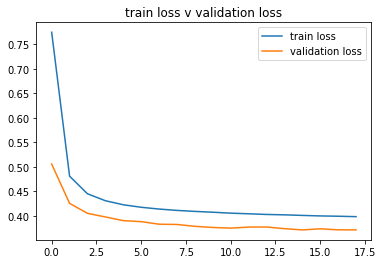

In [ ]:
# loss
import pandas as pd
import matplotlib.pyplot as plt

train_loss = pd.Series(cache['train_loss'])
val_loss = pd.Series(cache['valid_loss'])
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'validation loss')

plt.legend()
plt.title('train loss v validation loss')
plt.show()

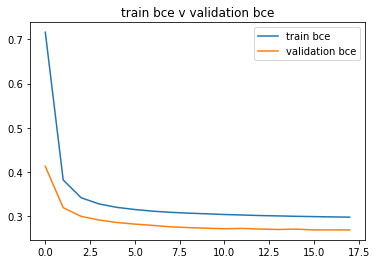

In [ ]:
# bce
train_bce = pd.Series(cache['train_bce'])
val_bce = pd.Series(cache['valid_bce'])
plt.plot(train_bce, label='train bce')
plt.plot(val_bce, label='validation bce')
plt.legend()
plt.title('train bce v validation bce')
plt.show()

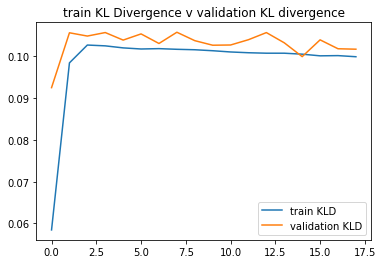

In [ ]:
# KL divergence
train_kld = pd.Series(cache['train_kld'])
val_kld = pd.Series(cache['valid_kld'])
plt.plot(train_kld, label='train KLD')
plt.plot(val_kld, label='validation KLD')
plt.legend()
plt.title('train KL Divergence v validation KL divergence')
plt.show()

### Evaluation
- **We provide the code below for sampling, interpolation, and marginal likelihood estimation**
- Sampling and interpolation: achieve similar to the lab (this is subjective, so the purpose is to check if something is *way off*)
- Marginal likelihood: achieve lower than the lab



*Please ensure that `model` contains the model state that you will use for evaluation before running these.*

#### Sampling

*no code modification needed*

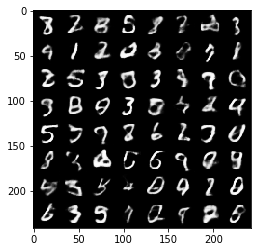

In [ ]:
from torchvision.utils import make_grid

model.load_state_dict(torch.load('model.pt')['state_dict'])
model.cuda();

N = 64
model.eval()

# Sample z~p(z)
z = torch.randn((N, zdim)).to(device)

# Decode
sample = model.decoder(z)

# Visualize
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

imgs = sample
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Interpolation

*no code modification needed*

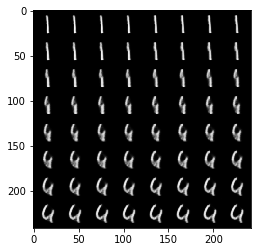

In [ ]:
model.eval()

x, y = next(train_loader.__iter__())
xhat, mu, logvar = model(x.cuda())
si, ei = np.random.choice(batch_size, size=2, replace=False)
start = mu[si]
end = mu[ei]

N = 64

zs = torch.zeros(N, zdim).to(device)
for i in range(N):
    zs[i] = i / (N) * start.data + (1 - i / (N) ) * end.data
xhat = model.decoder(zs)

imgs = xhat.unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Marginal likelihood

*no code modification needed*

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

eval_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)

N_samples = 128

model.eval()
results = []
with torch.no_grad():
  for i, (x, y) in tqdm_notebook(enumerate(eval_loader), total=len(eval_loader)):
    x, y = next(eval_loader.__iter__())
    x = x.to(device).expand(N_samples, 1, 28, 28)

    # Obtain mu, logvar and sample z
    _, mu, logvar = model(x)
    z = mu + logvar.mul(0.5).exp()*torch.randn_like(mu)

    # Obtain xhat given the sampled z
    xhat = model.decoder(z)

    # Make a standard normal for p(z) and a normal for q(z|x)
    norm = MultivariateNormal(
        torch.zeros_like(mu[0]), 
        covariance_matrix=torch.diag(torch.ones_like(logvar[0]))
    )
    mvn = MultivariateNormal(
        mu[0], 
        covariance_matrix=torch.diag(logvar.exp()[0])
    )

    # Measure the (log) probabilities needed for the formula above
    log_pz = norm.log_prob(z)
    log_qzx = mvn.log_prob(z)
    x = x.view(xhat.size())
    log_pxz = -nn.functional.binary_cross_entropy(
        xhat, x, reduction='none'
    ).view(N_samples, -1).sum(1)

    # Compute the lowerbound (in log space)
    argsum = log_pxz + log_pz - log_qzx
    logpx = -np.log(N_samples) + torch.logsumexp(argsum, 0)
    results.append(logpx.item())

np.mean(results)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


-96.87388866539001



---

# 2. Conditional variational autoencoder (20 points)

### A. Model

The conditional VAE involves:
- $q_{\phi}(\mathbf{z}|\mathbf{x},c)$: "encoder"
- $p_{\theta}(\mathbf{x}|\mathbf{z},c)$: "decoder"
- $p(\mathbf{z})$: prior

In our case, $c\in \{0,...,9\}$ is a discrete variable (class label).

**Your task:** Implement a `CVAE` that has an `encoder`, `decoder`, and `reparameterization`.

*Hints*: 
  1. Represent $c$ using a `nn.Embedding` layer, and concatenate it to the representation of $\mathbf{x}$.
    - e.g. $\mu = \texttt{linear([conv(x); emb(c)])}$
  2. Represent `decoder` inputs $\mathbf{z},c$ similarly, as $[\mathbf{z};\text{emb}(c)]$.
    - $\hat{x}=\texttt{deconv(linear([z; emb(c)]))}$

Otherwise, everything else is the same as VAE (plus passing $c$ as an argument in the right places). You can use the same convolutional layers as above.

In [ ]:
class CEncoder(nn.Module):
  def __init__(self, zdim=20, nclasses=10):
      super(CEncoder, self).__init__()
      self.en_conv = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),         
                                  # nn.BatchNorm2d(16),
                                  nn.ReLU(),
                                  
                                  nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),    
                                  # nn.BatchNorm2d(32),    
                                  nn.ReLU(),
                                  
                                  # nn.MaxPool2d(2,2),                                                            
                                  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),        
                                  # nn.BatchNorm2d(64),  
                                  nn.ReLU(),
                                  # nn.ReLU(),
                                  )
      # self.fc = nn.Linear(7 * 7 * 64 , 512)
      self.fc_mu = nn.Linear(7 * 7 * 64 + nclasses, zdim)
      self.fc_logvar = nn.Linear(7 * 7 * 64 + nclasses, zdim)


  def forward(self, x, c):
      x = self.en_conv(x)
      x = x.view(-1, 7 * 7 * 64)
      concat = torch.cat((x,c), dim = 1)
      # print(concat.shape)
      mu = self.fc_mu(concat)
      logvar = self.fc_logvar(concat)
      return mu, logvar
    


class CDecoder(nn.Module):
  def __init__(self, zdim=20, nclasses=10):
      super(CDecoder, self).__init__()
      self.fc = nn.Linear(zdim + nclasses, 7 * 7 * 64)
      self.de_conv = nn.Sequential(nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
                                  # nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  
                                  nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
                                  # nn.BatchNorm2d(16),  
                                  nn.ReLU(),
                                  nn.ConvTranspose2d(in_channels=16, out_channels=1,  kernel_size=3, stride=2, padding=1, output_padding=1),
                                  nn.Sigmoid(),
                                  )
    
  
  def forward(self, x, c):
      concat = torch.cat((x,c), dim = 1)
      out = self.fc(concat)
      out = out.view(-1, 64, 7, 7)
      out = self.de_conv(out)
      return out
    
    


class CVAE(nn.Module):
    def __init__(self, zdim=20, nclasses=10):
        super(CVAE, self).__init__()
        self.encoder = CEncoder(zdim, nclasses)
        self.decoder = CDecoder(zdim, nclasses)
    
    def reparameterize(self, mu, logvar):
        if self.training:
          std = torch.exp(0.5*logvar)
          eps = torch.randn_like(std)
          z = mu + std*eps
        else:
          z = mu
        return z
    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        xhat = self.decoder(z, c)
        return xhat, mu, logvar

In [ ]:
(images, label) = next(iter(test_loader))
label.to(device)
images.to(device)
y_one_hot = nn.functional.one_hot(label)
# print(y_one_hot)
# print(images.shape)
# enc = CEncoder()
# mu, logvar = enc(images, y_one_hot)
# dec = CDecoder()
# ret = dec(mu, y_one_hot)
# print(ret.shape)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 1, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])


**Loss:** same as VAE.

In [ ]:
def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
    BCE = nn.functional.binary_cross_entropy(
        xhat.view(x.size(0), -1), x.view(x.size(0), -1), reduction='none'
    ).sum(1).mean()
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

    loss = BCE + kl_weight*KLD
    return loss, BCE.item(), KLD.item()

### C. Training

Train your conditional VAE model using your loss function on MNIST.

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.


In [ ]:
import tqdm

def train(epoch, condition=False):
    model.train()
    train_loss, bce, kld = 0, 0, 0
    for batch_idx, (x, y) in tqdm.notebook.tqdm(enumerate(train_loader), total=len(train_loader)):
        x = x.to(device)

        if condition:
            y_one_hot = nn.functional.one_hot(y)
            y_one_hot = y_one_hot.to(device)
            xhat, mu, logvar = model(x, y_one_hot)
        else:
            xhat, mu, logvar = model(x)

        optimizer.zero_grad()
        loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        bce += bce_
        kld += kld_

    print('====> Epoch: {} Average loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        epoch, 
        train_loss / len(train_loader.dataset),
        bce / len(train_loader.dataset),
        kld / len(train_loader.dataset)
    ))
    return train_loss / len(train_loader.dataset), \
            bce / len(train_loader.dataset), \
            kld / len(train_loader.dataset)

def validate(epoch, condition=False):
    # mus, logvars, ys = [], [], []
    model.eval()
    test_loss, bce, kld = 0, 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x = x.to(device)
            if condition:
                y_one_hot = nn.functional.one_hot(y)
                y_one_hot = y_one_hot.to(device)
                xhat, mu, logvar = model(x, y_one_hot)
            else:
                xhat, mu, logvar = model(x)
            loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)

            test_loss += loss.item()
            bce += bce_
            kld += kld_

    test_loss /= len(test_loader.dataset)
    print('====> Valid set loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        test_loss,
        bce / len(test_loader.dataset),
        kld / len(test_loader.dataset)
    ))
    return test_loss, bce / len(test_loader.dataset), kld / len(test_loader.dataset)

In [ ]:
best_loss = 1e5
model = CVAE().to(device)
condition = True

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)

c_cache = dict(train_loss=[], train_bce=[], train_kld=[], valid_loss=[], valid_bce=[], valid_kld=[])
patience = 5
count = 0
for epoch in range(1, 30):
    train_loss_, train_bce_, train_kld_ = train(epoch, condition=condition)
    valid_loss_, valid_bce_, valid_kld_ = validate(epoch, condition=condition)

    c_cache['train_loss'].append(train_loss_)
    c_cache['train_bce'].append(train_bce_)
    c_cache['train_kld'].append(train_kld_)
    c_cache['valid_loss'].append(valid_loss_)
    c_cache['valid_bce'].append(valid_bce_)
    c_cache['valid_kld'].append(valid_kld_)

    if valid_loss_ < best_loss:
        torch.save({
            'state_dict': model.state_dict(),
            'valid_loss': c_cache['valid_loss']
        }, open('model.pt', 'wb'))
        best_loss = valid_loss_
    else:
        count += 1
    if (count == patience) :
        break


====> Epoch: 1 Average loss: 0.7777 (bce 0.7285, kld 0.0493)
====> Valid set loss: 0.4899 (bce 0.4125, kld 0.0774)



====> Epoch: 2 Average loss: 0.4695 (bce 0.3824, kld 0.0871)
====> Valid set loss: 0.4156 (bce 0.3218, kld 0.0939)



====> Epoch: 3 Average loss: 0.4331 (bce 0.3412, kld 0.0918)
====> Valid set loss: 0.3948 (bce 0.3008, kld 0.0940)



====> Epoch: 4 Average loss: 0.4191 (bce 0.3275, kld 0.0916)
====> Valid set loss: 0.3856 (bce 0.2912, kld 0.0944)



====> Epoch: 5 Average loss: 0.4111 (bce 0.3199, kld 0.0912)
====> Valid set loss: 0.3789 (bce 0.2859, kld 0.0930)



====> Epoch: 6 Average loss: 0.4059 (bce 0.3151, kld 0.0908)
====> Valid set loss: 0.3737 (bce 0.2826, kld 0.0910)



====> Epoch: 7 Average loss: 0.4019 (bce 0.3116, kld 0.0903)
====> Valid set loss: 0.3738 (bce 0.2795, kld 0.0943)



====> Epoch: 8 Average loss: 0.3990 (bce 0.3090, kld 0.0900)
====> Valid set loss: 0.3676 (bce 0.2784, kld 0.0891)



====> Epoch: 9 Average loss: 0.3964 (bce 0.3069, kld 0.0894)
====> Valid set loss: 0.3681 (bce 0.2761, kld 0.0920)



====> Epoch: 10 Average loss: 0.3941 (bce 0.3051, kld 0.0890)
====> Valid set loss: 0.3665 (bce 0.2767, kld 0.0899)



====> Epoch: 11 Average loss: 0.3923 (bce 0.3038, kld 0.0885)
====> Valid set loss: 0.3649 (bce 0.2735, kld 0.0914)



====> Epoch: 12 Average loss: 0.3907 (bce 0.3025, kld 0.0882)
====> Valid set loss: 0.3612 (bce 0.2739, kld 0.0873)



====> Epoch: 13 Average loss: 0.3892 (bce 0.3013, kld 0.0879)
====> Valid set loss: 0.3613 (bce 0.2722, kld 0.0891)



====> Epoch: 14 Average loss: 0.3877 (bce 0.3003, kld 0.0874)
====> Valid set loss: 0.3617 (bce 0.2728, kld 0.0888)



====> Epoch: 15 Average loss: 0.3866 (bce 0.2995, kld 0.0871)
====> Valid set loss: 0.3605 (bce 0.2707, kld 0.0897)



====> Epoch: 16 Average loss: 0.3857 (bce 0.2988, kld 0.0869)
====> Valid set loss: 0.3594 (bce 0.2706, kld 0.0887)



====> Epoch: 17 Average loss: 0.3846 (bce 0.2981, kld 0.0866)
====> Valid set loss: 0.3576 (bce 0.2695, kld 0.0881)



====> Epoch: 18 Average loss: 0.3834 (bce 0.2971, kld 0.0862)
====> Valid set loss: 0.3549 (bce 0.2693, kld 0.0856)



====> Epoch: 19 Average loss: 0.3824 (bce 0.2966, kld 0.0858)
====> Valid set loss: 0.3552 (bce 0.2686, kld 0.0866)


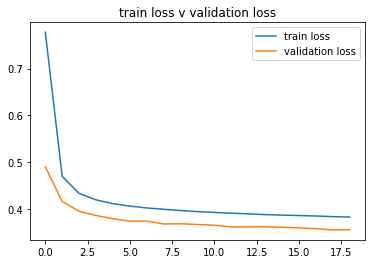

In [ ]:
# loss
train_loss = pd.Series(c_cache['train_loss'])
val_loss = pd.Series(c_cache['valid_loss'])
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'validation loss')

plt.legend()
plt.title('train loss v validation loss')
plt.show()

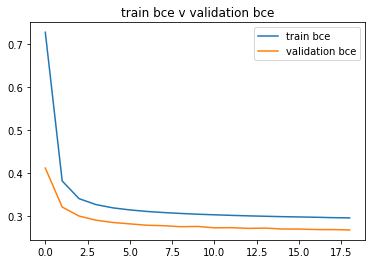

In [ ]:
# bce
train_bce = pd.Series(c_cache['train_bce'])
val_bce = pd.Series(c_cache['valid_bce'])
plt.plot(train_bce, label='train bce')
plt.plot(val_bce, label='validation bce')
plt.legend()
plt.title('train bce v validation bce')
plt.show()

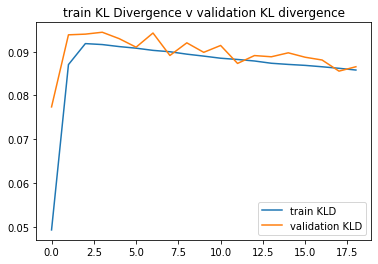

In [ ]:
# KL divergence
train_kld = pd.Series(c_cache['train_kld'])
val_kld = pd.Series(c_cache['valid_kld'])
plt.plot(train_kld, label='train KLD')
plt.plot(val_kld, label='validation KLD')
plt.legend()
plt.title('train KL Divergence v validation KL divergence')
plt.show()

### D. Conditional generation

**Your task**: complete the code below to produce a grid of samples with 10 rows, where the $i$'th row has samples of class $i$.

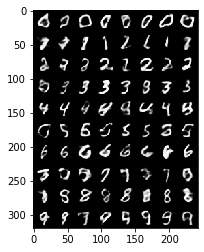

In [ ]:
from torchvision.utils import make_grid
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def one_hot(y, class_count):
    return torch.eye(class_count)[y,:]

N = 8
model.eval()
grids = []
for y_ in range(10):
  
  c = one_hot(y_, 10)
  c = c.repeat(N,1)
  c = c.to(device)
  z = torch.randn((N, zdim)).to(device)
  
  sample = model.decoder(z, c)


  grid = make_grid(sample).detach().cpu()
  grids.append(grid)

grid = torch.cat(grids, 1)
show(grid);